In [1]:
import cv2 as cv
import os
from matplotlib import pyplot as plt
import numpy as np
import random
import uuid

# Define a random seed
# random_seed = 42  # You can choose any integer value

# Set the random seed
# random.seed(random_seed)

In [2]:
# folder_path = os.path.join('Images','MMU-Iris-Database')
folder_path = os.path.join('Images','IITD-Database')

folder_path

'Images/IITD-Database'

In [3]:
def get_particular_image(file_path):
    if not os.path.isfile(file_path):
        print(f"File '{file_path}' does not exist.")
        return None
    
    # Load the image using OpenCV
    main_image = cv.imread(file_path)
    if main_image is None:
        print(f"Unable to read image from '{file_path}'.")
        return None
    
    return main_image

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


In [4]:
def get_random_file(root_folder):
    # Get a list of all files (recursively) in the folder
    all_files = []
    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            all_files.append(file_path)
    # Check if there are any files in the folder
    if not all_files:
        print("No files found in the specified folder.")
        return None

    # Choose a random file
    random_file = random.choice(all_files)
    return random_file

In [5]:
def get_random_image(folder_path):
    random_file_path = get_random_file(folder_path)
    print(random_file_path)
    image = cv.imread(random_file_path)
    if image is None:
        print ('Error opening image!')
    return image


In [6]:
def preprocess(main_image):
    # Convert image to gray
    gray_image = cv.cvtColor(main_image, cv.COLOR_BGR2GRAY)
    rows, cols = gray_image.shape
    
    # Reduce noise with median blur
    median_blurred_image = cv.medianBlur(gray_image, 9)
    return median_blurred_image

In [7]:
def detect_circles(preprocessed_image, min_radius, max_radius,radius_diff,expected_radius_diff):
    # Detect circles using Hough transform
    circles = cv.HoughCircles(preprocessed_image, cv.HOUGH_GRADIENT, dp=1, minDist=preprocessed_image.shape[0]//8,
                              param1=100, param2=30,
                              minRadius=min_radius, maxRadius=max_radius)
    
    # Check if circles are detected
    if circles is None or len(circles) != 1:
        raise ValueError("Error: Incorrect number of circles detected.")
    
    # Extract pupil center and radius
    pupil_center = (circles[0, 0, 0], circles[0, 0, 1])
    pupil_radius = circles[0, 0, 2]
    
    # Extract iris radius using intensity analysis
    rows, cols = preprocessed_image.shape
    xc, yc = pupil_center
    radius_range = range(int(pupil_radius * 1.4), int(pupil_radius * 2.4))
    intensity_sum = np.zeros(len(radius_range))

    for i, radius in enumerate(radius_range):
        for theta in range(0, 360):
            x = int(xc + radius * np.cos(np.deg2rad(theta)))
            y = int(yc - radius * np.sin(np.deg2rad(theta)))
            if 0 <= x < cols and 0 <= y < rows:
                intensity_sum[i] += preprocessed_image[y, x]

    iris_radius = min_radius  # Default value
    max_val = float('-inf')
    for i in range(2, len(intensity_sum) - 2):
        val = intensity_sum[i + 2] + intensity_sum[i + 1] - intensity_sum[i - 1] - intensity_sum[i - 2]
        if val > max_val and (radius_range[i] - pupil_radius) > radius_diff:
            max_val = val
            iris_radius = radius_range[i]
            
    pupil_center = tuple(map(int, pupil_center))
    pupil_radius = int(pupil_radius)
    iris_radius = int(iris_radius)
    
    if (iris_radius-pupil_radius< expected_radius_diff):
        raise ValueError("radius differencd too small")

    return pupil_center, pupil_radius, iris_radius


In [8]:
# def custom_sobel_filter(image):
#     # Define the Sobel filter kernel
#     kernel_y = np.array([[1, 2, 1],
#                          [0, 0, 0],
#                          [-1, -2, -1]])

#     # Perform convolution with the image and the kernels
#     sobel_y = cv.filter2D(image, -1, kernel_y)

#     # Compute the magnitude of the gradient
#     sobel_magnitude = np.square(sobel_y)
    
#     return sobel_magnitude


# def sobel_filter(image, pupil_center, pupil_radius, iris_radius, threshold):
#     xc, yc = pupil_center
#     length = pupil_radius * 2
#     height = iris_radius - pupil_radius
#     start_point_upper = (int(xc - length / 2), yc - iris_radius)
#     end_point_upper = (int(xc + length / 2), yc - pupil_radius - 5)
#     start_point_lower = (int(xc - length / 2), yc + iris_radius)
#     end_point_lower = (int(xc + length / 2), yc + pupil_radius + 5)

#     # Ensure coordinates are non-negative
#     xmin, ymin = start_point_upper
#     xmax, ymax = end_point_upper
#     xmin = max(0, xmin)
#     ymin = max(0, ymin)
#     xmax = max(0, xmax)
#     ymax = max(0, ymax)

#     sobel_matrix_upper = custom_sobel_filter(image[ymin:ymax, xmin:xmax])
#     sobel_matrix_lower = custom_sobel_filter(image[start_point_lower[1]:end_point_lower[1], start_point_lower[0]:end_point_lower[0]])

#     # Compute edge counts
#     edge_counts_upper = np.sum(sobel_matrix_upper, axis=1)
#     edge_counts_lower = np.sum(sobel_matrix_lower, axis=1)

#     # Normalize edge counts
#     total_edge_count_upper = np.sum(edge_counts_upper)
#     total_edge_count_lower = np.sum(edge_counts_lower)
#     edge_counts_normalized_upper = edge_counts_upper / total_edge_count_upper if total_edge_count_upper != 0 else np.zeros_like(edge_counts_upper)
#     edge_counts_normalized_lower = edge_counts_lower / total_edge_count_lower if total_edge_count_lower != 0 else np.zeros_like(edge_counts_lower)

#     # Find eyelid rows
#     max_edge_upper = np.max(edge_counts_normalized_upper)
#     max_edge_lower = np.max(edge_counts_normalized_lower)
#     print(f"Max Edge Lower Intensity: {max_edge_lower}, Max Edge Upper Intensity: {max_edge_upper}")

#     eyelid_row_upper = ymin + np.argmax(edge_counts_normalized_upper) if max_edge_upper >= threshold else yc - iris_radius
#     eyelid_row_lower = start_point_lower[1] + np.argmax(edge_counts_normalized_lower) if max_edge_lower >= threshold else yc + iris_radius

#     eyelid_row_upper = max(0, eyelid_row_upper)
#     eyelid_row_lower = min(eyelid_row_lower, image.shape[0] - 1)
    
#     return eyelid_row_upper, eyelid_row_lower


In [9]:
# def custom_sobel_filter(image, xmin, xmax, ymin, ymax):
#     # Initialize Sobel matrix
#     sobel_matrix = np.zeros((ymax - ymin, xmax - xmin))

#     # Compute Sobel filtering using loop-based implementation
#     for i in range(ymin, ymax):
#         for j in range(xmin, xmax):
#             sobel_matrix[i - ymin][j - xmin] = abs(
#                 -image[i - 1][j - 1] - 2 * image[i][j - 1] - image[i + 1][j - 1] +
#                 image[i - 1][j + 1] + 2 * image[i][j + 1] + image[i + 1][j + 1]
#             )  # Transposed indexing

#     return sobel_matrix
def custom_sobel_filter(image, xmin, xmax, ymin, ymax):
    # Initialize Sobel matrix
    sobel_matrix = np.zeros((ymax - ymin, xmax - xmin))

    # Compute Sobel filtering using loop-based implementation
    for i in range(ymin, ymax):
        for j in range(xmin, xmax):
            # Check if indices are within bounds
            if i - 1 >= 0 and j - 1 >= 0 and i + 1 < image.shape[0] and j + 1 < image.shape[1]:
                sobel_matrix[i - ymin][j - xmin] = abs(
                    -image[i - 1][j - 1] - 2 * image[i][j - 1] - image[i + 1][j - 1] +
                    image[i - 1][j + 1] + 2 * image[i][j + 1] + image[i + 1][j + 1]
                )  # Transposed indexing
            else:
                sobel_matrix[i - ymin][j - xmin] = 0

    return sobel_matrix


def sobel_filter(image, pupil_center, pupil_radius, iris_radius, threshold):
    xc, yc = pupil_center
    length = pupil_radius * 2
    height = iris_radius - pupil_radius
    start_point_upper = (int(xc - length / 2), yc - iris_radius)
    end_point_upper = (int(xc + length / 2), yc - pupil_radius - 5)
    start_point_lower = (int(xc - length / 2), yc + iris_radius)
    end_point_lower = (int(xc + length / 2), yc + pupil_radius + 5)

    # Ensure coordinates are non-negative
    xmin_upper, ymin_upper = start_point_upper
    xmax_upper, ymax_upper = end_point_upper
    xmin_upper = max(0, xmin_upper)
    ymin_upper = max(0, ymin_upper)
    xmax_upper = max(0, xmax_upper)
    ymax_upper = max(0, ymax_upper)
    # For the lower region
    xmin_lower, ymax_lower = start_point_lower
    xmax_lower, ymin_lower = end_point_lower
    
    # Call custom_sobel_filter for upper and lower regions
    sobel_matrix_upper = custom_sobel_filter(image, xmin_upper, xmax_upper, ymin_upper, ymax_upper)
    sobel_matrix_lower = custom_sobel_filter(image, xmin_lower, xmax_lower, ymin_lower, ymax_lower)

    # Compute edge counts
    edge_counts_upper = np.sum(sobel_matrix_upper, axis=1)
    edge_counts_lower = np.sum(sobel_matrix_lower, axis=1)

    # Normalize edge counts
    total_edge_count_upper = np.sum(edge_counts_upper)
    total_edge_count_lower = np.sum(edge_counts_lower)
    edge_counts_normalized_upper = edge_counts_upper / total_edge_count_upper if total_edge_count_upper != 0 else np.zeros_like(edge_counts_upper)
    edge_counts_normalized_lower = edge_counts_lower / total_edge_count_lower if total_edge_count_lower != 0 else np.zeros_like(edge_counts_lower)

    # Find eyelid rows
    max_edge_upper = np.max(edge_counts_normalized_upper)
    max_edge_lower = np.max(edge_counts_normalized_lower)
    # print(f"Max Edge Lower Intensity: {max_edge_lower}, Max Edge Upper Intensity: {max_edge_upper}")

    eyelid_row_upper = ymin_upper + np.argmax(edge_counts_normalized_upper) if max_edge_upper >= threshold else yc - iris_radius
    eyelid_row_lower = ymin_lower + np.argmax(edge_counts_normalized_lower) if max_edge_lower >= threshold else yc + iris_radius

    eyelid_row_upper = max(0, eyelid_row_upper)
    eyelid_row_lower = min(eyelid_row_lower, image.shape[0] - 1)
    return eyelid_row_upper, eyelid_row_lower


In [10]:
def generate_circle_masks(center, radius1, radius2, shape):
    black_background = np.zeros(shape[:2], dtype=np.uint8)
    mask1 = cv.circle(black_background.copy(), center, radius1, 255, -1)
    mask2 = cv.circle(black_background.copy(), center, radius2, 255, -1)
    mask = cv.subtract(mask2, mask1)
    return mask1, mask2, mask

def apply_mask(image, mask):
    result = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    result = cv.bitwise_and(result, mask)
    return result

def extract_result_region(result, eyelid_row_upper, eyelid_row_lower, yc, iris_radius):
    if eyelid_row_upper is not None:
        result = result[eyelid_row_upper:, :]
        a = eyelid_row_upper
    else:
        result = result[yc - iris_radius:, :]
        a = yc - iris_radius
    if eyelid_row_lower:
        result = result[: eyelid_row_lower - a, :]
    else:
        result = result[:iris_radius - a, :]
    return result

def extract_iris_region(result, xc, iris_radius):
    result = result[:, xc - iris_radius:xc + iris_radius]
    xc, yc = result.shape[0] // 2, result.shape[1] // 2
    return result, xc, yc

def rubber_sheet_mapping(iris_image, r1, r2, xc, yc):
    gray = iris_image
    radial_resolution=r2-r1
    pupil_center = (xc, yc)
    theta_steps = 360
    theta_range = np.linspace(0, 2*np.pi, theta_steps)
    normalized_iris = np.zeros((r2-r1, theta_steps), dtype=np.uint8)
    for r in range(radial_resolution):
        for theta_idx, theta in enumerate(theta_range):
            x_polar = pupil_center[0] + (r1+r) * np.cos(theta)
            y_polar = pupil_center[1] + (r1+r) * np.sin(theta)
            x_polar = max(0, min(gray.shape[1] - 1, int(x_polar)))
            y_polar = max(0, min(gray.shape[0] - 1, int(y_polar)))           
            normalized_iris[r, theta_idx] = gray[int(y_polar), int(x_polar)]
    return normalized_iris

def process_image(main_image_backup, pupil_center, pupil_radius, iris_radius, eyelid_row_upper, eyelid_row_lower):
    hh, ww = main_image_backup.shape[:2]
    mask1, mask2, mask = generate_circle_masks(pupil_center, pupil_radius, iris_radius, (hh, ww))
    result = apply_mask(main_image_backup, mask)
    result = extract_result_region(result, eyelid_row_upper, eyelid_row_lower, pupil_center[1], iris_radius)
    result, xc, yc = extract_iris_region(result, pupil_center[0], iris_radius)
    return result, xc, yc

In [11]:
# def enhance_iris(image):
#     # Split the image into its color channels
#     channels = cv.split(image)

#     # Initialize a list to store the enhanced iris channels
#     enhanced_channels = []

#     # Process each channel individually
#     for channel in channels:
#         # Apply threshold to separate reflection noise
#         _, reflection_mask = cv.threshold(channel, 200, 255, cv.THRESH_BINARY)

#         # Apply threshold to remove pupil noise
#         _, pupil_noise_mask = cv.threshold(channel, 150, 255, cv.THRESH_BINARY_INV)

#         # Combine masks to remove both reflection and pupil noise
#         iris_mask = cv.bitwise_and(reflection_mask, pupil_noise_mask)

#         # Apply the iris mask to the channel
#         enhanced_channel = cv.bitwise_and(channel, iris_mask)

#         # Store the enhanced channel
#         enhanced_channels.append(enhanced_channel)

#     # Merge the enhanced channels back into a three-dimensional image
#     enhanced_iris = cv.merge(enhanced_channels)

#     return enhanced_iris

def normalize_enchance_image(main_image,min_radius,max_radius,threshold,radius_diff,expected_radius_diff):
    preprocessed_image=preprocess(main_image)
    pupil_center, pupil_radius, iris_radius = detect_circles(preprocessed_image, min_radius,max_radius,radius_diff,expected_radius_diff)
    eyelid_row_upper, eyelid_row_lower = sobel_filter(preprocessed_image,pupil_center, pupil_radius, iris_radius,threshold=threshold)
    result, pupil_center_x, pupil_center_y = process_image(main_image, pupil_center, pupil_radius, iris_radius, eyelid_row_upper, eyelid_row_lower)
    normalized_image = rubber_sheet_mapping(result, pupil_radius, iris_radius, pupil_center_x, pupil_center_y)
    clahe = cv.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
    enhanced_iris = clahe.apply(normalized_image)
    enhanced_iris = cv.cvtColor(enhanced_iris, cv.COLOR_GRAY2BGR)
    # enhanced_iris = enhance_iris(enhanced_iris)
    return result,normalized_image,enhanced_iris

In [12]:
def normalize_enchance_image_for_hist(main_image,min_radius,max_radius,threshold):
    preprocessed_image=preprocess(main_image)
    pupil_center, pupil_radius, iris_radius = detect_circles(preprocessed_image, min_radius,max_radius,radius_diff=0,expected_radius_diff=0)
   
    return pupil_center, pupil_radius, iris_radius

Images/IITD-Database/124/07_R.bmp
Image loaded successfully.


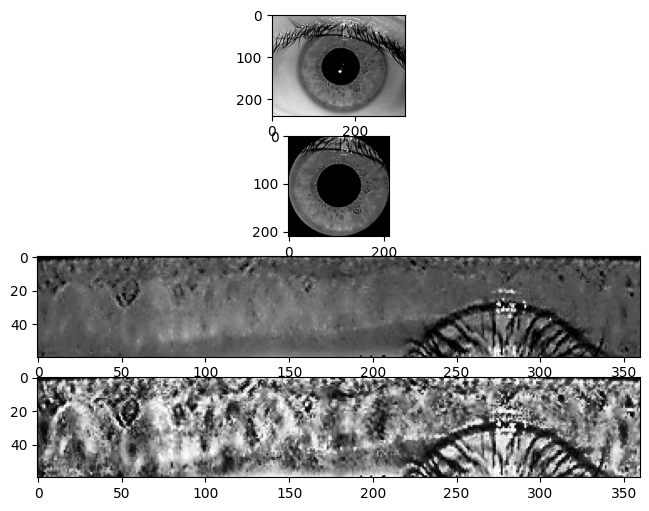

In [14]:
fig, axs = plt.subplots(4, 1, figsize=(12, 6))


main_image=get_random_image(folder_path)
# file_path='Images/IITD-Database/198/10_R.bmp'
# main_image=get_particular_image(file_path)


if main_image is not None:
    print("Image loaded successfully.")
else:
    print("Failed to load image.")
draw_image=main_image.copy()
main_image_backup=main_image.copy()


# result,normalized_image,enhanced_iris=normalize_enchance_image(main_image,20,80,1)
result,normalized_image,enhanced_iris=normalize_enchance_image(main_image,10,50,1,20,expected_radius_diff=25)


axs[0].imshow(main_image)
axs[1].imshow(result, cmap='gray')

# Display normalized image
axs[2].imshow(normalized_image, cmap='gray')


axs[3].imshow(enhanced_iris)

# Show the plot
plt.show()

In [15]:
def normalize_images_in_folder(source_folder, destination_folder):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    # Initialize error count
    error_count = 0
    
    # Iterate over all files in the source folder
    for filename in os.listdir(source_folder):
        # Ignore .DS_Store and .ipynb_checkpoints
        if filename == ".DS_Store" or filename.startswith(".ipynb_checkpoints"):
            continue

        try:
            # Read the image
            file_path = os.path.join(source_folder, filename)
            image = cv.imread(file_path)

            # Normalize the image
            result, normalized_image, enhanced_iris = normalize_enchance_image(image, 10, 50, 1, 20, expected_radius_diff=18)
            # result, normalized_image, enhanced_iris = normalize_enchance_image_for_hist(image, 10, 50, 1, 20)

            # Save the normalized image to the destination folder
            destination_path = os.path.join(destination_folder, filename)
            cv.imwrite(destination_path, enhanced_iris)
        except Exception as e:
            # Increment error count
            error_count += 1
            # print(f"Error processing {filename}: {e}")

    # Print the total number of errors encountered
    print(f"Total number of errors: {error_count}")

In [16]:
def get_radius_data_for_plot(source_folder):
    global     pupil_radi, iris_radii,diff_radii
    # Initialize error count
    error_count = 0
    
    # Initialize arrays to store pupil and iris radii

    
    # Iterate over all files in the source folder
    for filename in os.listdir(source_folder):
        # Ignore .DS_Store and .ipynb_checkpoints
        if filename == ".DS_Store" or filename.startswith(".ipynb_checkpoints"):
            continue

        try:
            # Read the image
            file_path = os.path.join(source_folder, filename)
            image = cv.imread(file_path)

            # Normalize the image
            pupil_center, pupil_radius, iris_radius = normalize_enchance_image_for_hist(image, 10, 50, 1)
            
            # Append radii to arrays
            pupil_radii.append(pupil_radius)
            iris_radii.append(iris_radius)
            diff_radii.append(iris_radius-pupil_radius)

        except Exception as e:
            # Increment error count
            error_count += 1
            # print(f"Error processing {filename}: {e}")


    # Print the total number of errors encountered
    print(f"Total number of errors: {error_count}")


In [17]:
%%time
source_folder = "all-images-iit"
destination_folder = "all-images-iit-normalized-3"
normalize_images_in_folder(source_folder, destination_folder)


Total number of errors: 252
CPU times: user 2min 34s, sys: 2.24 s, total: 2min 36s
Wall time: 2min 37s


In [17]:
# %%time
# source_folder = "all-images-mmu"
# destination_folder = "all-images-mmu-normalized-denoise-and-dereflect"
# normalize_images_in_folder(source_folder, destination_folder)


In [15]:
pupil_radii = []
iris_radii = []
diff_radii=[]
source_folder = source_folder = "all-images-iit"
get_radius_data_for_plot(source_folder)

Total number of errors: 248


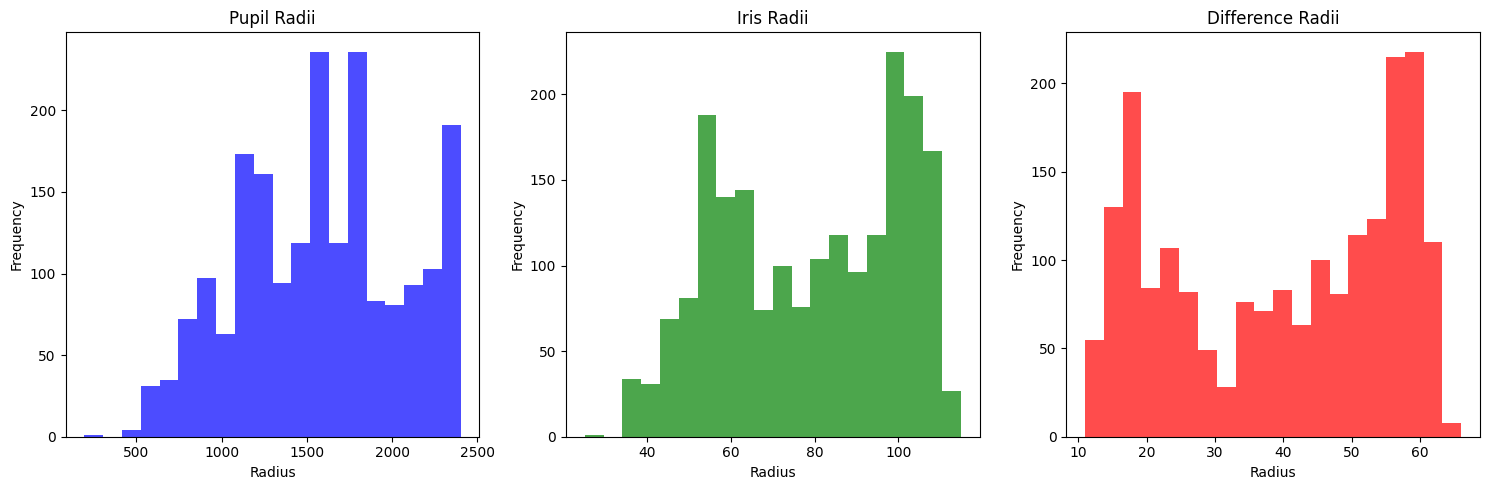

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))


# Plot histograms
axs[0].hist(np.square(pupil_radii), bins=20, color='blue', alpha=0.7)
axs[0].set_title('Pupil Radii')
axs[0].set_xlabel('Radius')
axs[0].set_ylabel('Frequency')

axs[1].hist(iris_radii, bins=20, color='green', alpha=0.7)
axs[1].set_title('Iris Radii')
axs[1].set_xlabel('Radius')
axs[1].set_ylabel('Frequency')

axs[2].hist(diff_radii, bins=20, color='red', alpha=0.7)
axs[2].set_title('Difference Radii')
axs[2].set_xlabel('Radius')
axs[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [54]:
pupil_radii_arr = np.array(pupil_radii)
iris_radii_arr = np.array(iris_radii)
diff_radii_arr = np.array(diff_radii)
# Calculate mean
from scipy import stats
pupil_mean = np.mean(pupil_radii_arr)
iris_mean = np.mean(iris_radii_arr)
diff_mean = np.mean(diff_radii_arr)

# Calculate standard deviation
pupil_sd = np.std(pupil_radii_arr)
iris_sd = np.std(iris_radii_arr)
diff_sd = np.std(diff_radii_arr)

# Calculate 99% confidence interval
pupil_ci = stats.norm.interval(0.99, loc=pupil_mean, scale=pupil_sd / np.sqrt(len(pupil_radii_arr)))
iris_ci = stats.norm.interval(0.99, loc=iris_mean, scale=iris_sd / np.sqrt(len(iris_radii_arr)))
diff_ci = stats.norm.interval(0.99, loc=diff_mean, scale=diff_sd / np.sqrt(len(diff_radii_arr)))

print("Pupil Radius:")
print(f"Mean: {pupil_mean}")
print(f"Standard Deviation: {pupil_sd}")
print(f"99% Confidence Interval: {pupil_ci}")

print("\nIris Radius:")
print(f"Mean: {iris_mean}")
print(f"Standard Deviation: {iris_sd}")
print(f"99% Confidence Interval: {iris_ci}")

print("\nDifference Radius:")
print(f"Mean: {diff_mean}")
print(f"Standard Deviation: {diff_sd}")
print(f"99% Confidence Interval: {diff_ci}")

Pupil Radius:
Mean: 39.28012048192771
Standard Deviation: 6.2127481312953465
99% Confidence Interval: (38.92156517077548, 39.63867579307994)

Iris Radius:
Mean: 78.94979919678715
Standard Deviation: 21.467414597894898
99% Confidence Interval: (77.71085382863212, 80.18874456494218)

Difference Radius:
Mean: 39.66967871485944
Standard Deviation: 16.543763439197175
99% Confidence Interval: (38.71489121628214, 40.62446621343673)


In [118]:
# from concurrent.futures import ThreadPoolExecutor

# def normalize_image(file_path, source_folder, destination_folder):
#     try:
#         # Read the image
#         image = cv.imread(file_path)

#         # Normalize the image
#         result, normalized_image, enhanced_iris = normalize_enchance_image(image, 10, 50, 1, 20, expected_radius_diff=25)

#         # Save the normalized image to the destination folder
#         filename = os.path.basename(file_path)
#         destination_path = os.path.join(destination_folder, filename)
#         cv.imwrite(destination_path, enhanced_iris)
#     except Exception as e:
#         pass

# def normalize_images_in_folder(source_folder, destination_folder):
#     # Create the destination directory if it doesn't exist
#     if not os.path.exists(destination_folder):
#         os.makedirs(destination_folder)
    
    
#     # List all files in the source folder
#     files = [os.path.join(source_folder, filename) for filename in os.listdir(source_folder)
#              if not (filename == ".DS_Store" or filename.startswith(".ipynb_checkpoints"))]
    
#     # Process images in parallel using threads
#     with ThreadPoolExecutor() as executor:
#         for file_path in files:
#             executor.submit(normalize_image, file_path, source_folder, destination_folder)

#     # Print the total number of errors encountered
#     print(f"Total number of errors: {error_count}")



In [119]:
# %%time
# source_folder = "all-images-iit"
# destination_folder = "all-images-iit-normalized-multithreded"
# normalize_images_in_folder(source_folder, destination_folder)


/var/folders/wz/gn9kr9314tg4sf_j23fdrzzh0000gn/T/ipykernel_542/2965288895.py:24: RuntimeWarning: overflow encountered in scalar negative
  -image[i - 1][j - 1] - 2 * image[i][j - 1] - image[i + 1][j - 1] +


Total number of errors: 0
CPU times: user 2min 22s, sys: 5.1 s, total: 2min 27s
Wall time: 2min 19s


In [ ]:
# save_file_name = uuid.uuid4()
# save_path=os.path.join("Images",f"{save_file_name}.bmp")

# cv.imwrite(save_path,enhanced_iris)

# go up and fix threshold

In [ ]:
preprocessed_image=preprocess(main_image)
plt.imshow(preprocessed_image,cmap='gray')

In [669]:
pupil_center, pupil_radius, iris_radius = detect_circles(preprocessed_image, 20, 50,20)
pupil_center, pupil_radius, iris_radius

((163, 101), 24, 45)

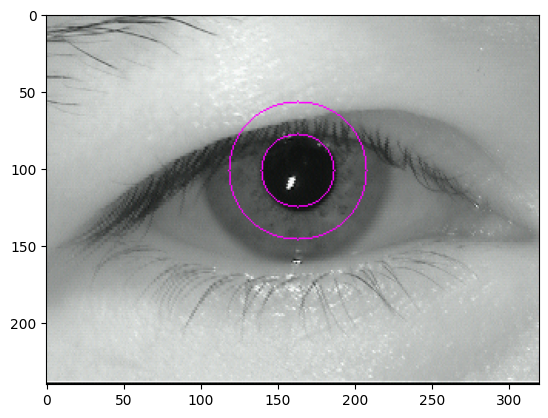

In [670]:
# Draw circle for pupil
cv.circle(draw_image, pupil_center, pupil_radius, (255, 0, 255), thickness=1)  # Green circle for pupil

# Draw circle for iris
cv.circle(draw_image, pupil_center, iris_radius, (255, 0, 255), thickness=1)  # Red circle for iris
plt.imshow(draw_image)

In [673]:
eyelid_row_upper, eyelid_row_lower = sobel_filter(preprocessed_image,pupil_center, pupil_radius, iris_radius,threshold=1)
eyelid_row_upper, eyelid_row_lower

Max Edge Lower Intensity: 0.06277140531714295, Max Edge Upper Intensity: 0.06373398723206358


/var/folders/wz/gn9kr9314tg4sf_j23fdrzzh0000gn/T/ipykernel_94692/1580029095.py:24: RuntimeWarning: overflow encountered in scalar negative
  -image[i - 1][j - 1] - 2 * image[i][j - 1] - image[i + 1][j - 1] +


(56, 146)

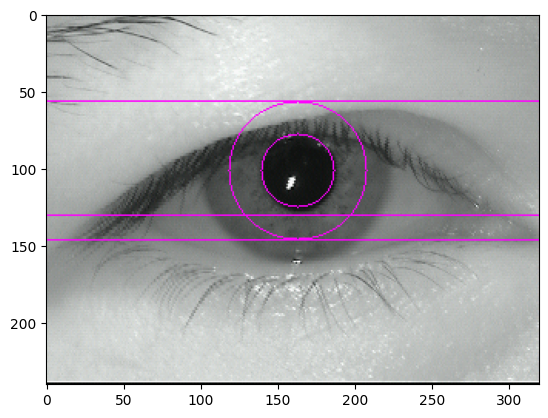

In [674]:
cv.line(draw_image, (0, eyelid_row_upper), (draw_image.shape[1], eyelid_row_upper), (255, 0, 255), thickness=1)
cv.line(draw_image, (0, eyelid_row_lower), (draw_image.shape[1], eyelid_row_lower), (255, 0, 255), thickness=1)
plt.imshow(draw_image, cmap='gray')


In [601]:
result, pupil_center_x, pupil_center_y = process_image(main_image, pupil_center, pupil_radius, iris_radius, eyelid_row_upper, eyelid_row_lower)
normalized_image = rubber_sheet_mapping(result, pupil_radius, iris_radius, pupil_center_x, pupil_center_y)

clahe = cv.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
enhanced_iris = clahe.apply(normalized_image)

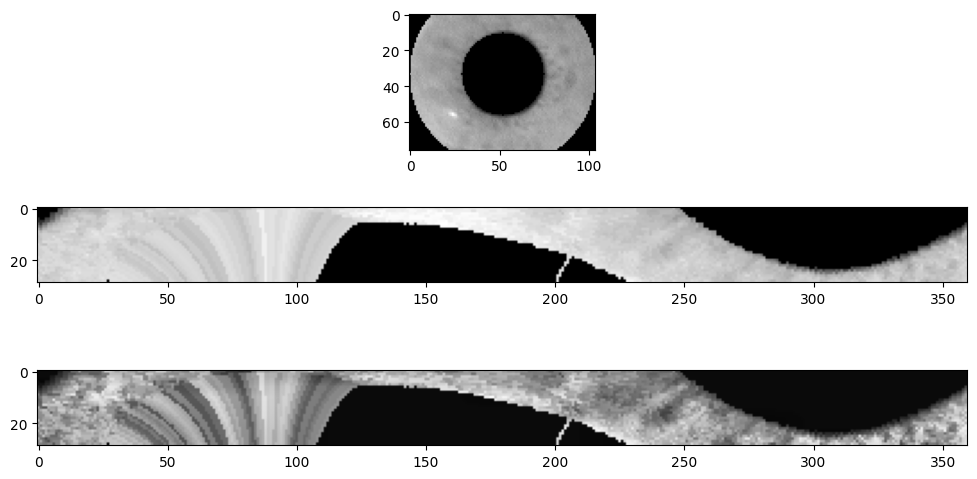

In [602]:
fig, axs = plt.subplots(3, 1, figsize=(12, 6))
axs[0].imshow(result, cmap='gray')

# Display normalized image
axs[1].imshow(normalized_image, cmap='gray')

axs[2].imshow(enhanced_iris, cmap='gray')

# Show the plot
plt.show()